⏳ Iniciando proceso de actualización de cotizaciones...
   📥 Descargando historial ARS=X...


/tmp/ipykernel_3164/1707714025.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_dolar = yf.download("ARS=X", start="2019-01-01", end="2025-12-31", progress=False)


   ✅ Se procesaron 2545 días.
   💵 Valor Actual: $1450.50

📈 Generando gráfico de evolución cambiaria...


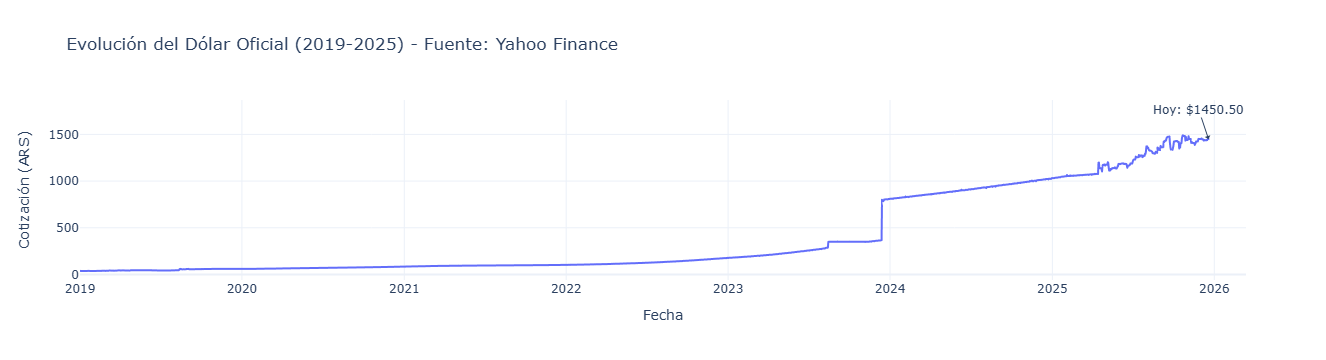

   💾 Guardando en PostgreSQL...

🎉 ¡ÉXITO! Tabla 'dim_cotizaciones' actualizada correctamente.


In [3]:
import yfinance as yf
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine, text

# =============================================================================
# 1. CONFIGURACIÓN DE CONEXIÓN
# =============================================================================
# Usamos 'postgres' como host (red interna Docker)
DB_USER = 'analista_medhos'
DB_PASS = 'Medhos2025!'
DB_HOST = 'postgres' 
DB_PORT = '5432'
DB_NAME = 'medhos_dw'

connection_str = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_str)

print("⏳ Iniciando proceso de actualización de cotizaciones...")

# =============================================================================
# 2. DESCARGA DE DATOS (YAHOO FINANCE)
# =============================================================================
# Ticker ARS=X: Dólar Oficial Mayorista
try:
    print("   📥 Descargando historial ARS=X...")
    df_dolar = yf.download("ARS=X", start="2019-01-01", end="2025-12-31", progress=False)
    
    # Ajuste de formato para versiones nuevas de yfinance
    if isinstance(df_dolar.columns, pd.MultiIndex):
        df_dolar = df_dolar['Close']
    else:
        df_dolar = df_dolar[['Close']]
        
    df_dolar = df_dolar.reset_index()
    df_dolar.columns = ['fecha', 'tipo_cambio_oficial_venta']
    df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha']).dt.date

    # Rellenar fines de semana (Forward Fill)
    rango_fechas = pd.date_range(start=df_dolar['fecha'].min(), end=df_dolar['fecha'].max())
    df_completo = pd.DataFrame({'fecha': rango_fechas.date})
    
    df_final = df_completo.merge(df_dolar, on='fecha', how='left')
    df_final['tipo_cambio_oficial_venta'] = df_final['tipo_cambio_oficial_venta'].ffill()

    print(f"   ✅ Se procesaron {len(df_final)} días.")
    print(f"   💵 Valor Actual: ${df_final.iloc[-1]['tipo_cambio_oficial_venta']:.2f}")

    # =============================================================================
    # 3. VISUALIZACIÓN (GRÁFICO DE TENDENCIA)
    # =============================================================================
    print("\n📈 Generando gráfico de evolución cambiaria...")
    
    fig = px.line(
        df_final, 
        x='fecha', 
        y='tipo_cambio_oficial_venta',
        title='Evolución del Dólar Oficial (2019-2025) - Fuente: Yahoo Finance',
        labels={'fecha': 'Fecha', 'tipo_cambio_oficial_venta': 'Cotización (ARS)'},
        template='plotly_white'
    )
    
    # Agregar un indicador del valor actual
    ultimo_valor = df_final.iloc[-1]['tipo_cambio_oficial_venta']
    ultima_fecha = df_final.iloc[-1]['fecha']
    
    fig.add_annotation(
        x=ultima_fecha, y=ultimo_valor,
        text=f"Hoy: ${ultimo_valor:.2f}",
        showarrow=True, arrowhead=1
    )
    
    fig.show()

    # =============================================================================
    # 4. GUARDADO EN BASE DE DATOS
    # =============================================================================
    print("   💾 Guardando en PostgreSQL...")
    df_final.to_sql('dim_cotizaciones', engine, if_exists='replace', index=False)
    
    # Crear Primary Key
    with engine.begin() as con:
        con.execute(text("ALTER TABLE dim_cotizaciones ADD PRIMARY KEY (fecha);"))
        
    print("\n🎉 ¡ÉXITO! Tabla 'dim_cotizaciones' actualizada correctamente.")

except Exception as e:
    print(f"\n❌ ERROR: {e}")